# ER / NR discrimination test

In [1]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
%run _if_on_colab_setup_flamedisx.ipynb

File ‘_if_on_colab_setup_flamedisx.ipynb’ already there; not retrieving.

Flamedisx is installed :-)


In [2]:
import gzip
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from multihist import Hist1d, Histdd
import numpy as np
from scipy import stats
import tensorflow as tf
from tqdm import tqdm

import flamedisx as fd

have_gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"Running tensorflow {tf.__version__}, GPU {'active' if have_gpu else 'NOT ACTIVE!'}")

Running tensorflow 2.1.0, GPU NOT ACTIVE!


## Initialization

In [3]:
class LowMassWIMPSource(fd.x1t_sr0.SR0WIMPSource):
    mw = 30  # GeV
    pretend_wimps_dont_modulate = True


class LowMassWIMPModulationSource(LowMassWIMPSource):
    pretend_wimps_dont_modulate = False


class LowEnergyERSource(fd.x1t_sr0.SR0ERSource):
    def _single_spectrum(self):
        """Return (energies in keV, rate at these energies),
        """
        return (tf.dtypes.cast(
                    tf.linspace(0., 5., 1000),  # 10 keV for 1 TeV WIMP
                    dtype=fd.float_type()),
                tf.ones(1000, dtype=fd.float_type()))

def add_corrected_signals(d):
    d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
        d['photon_detection_eff'] * d['photon_gain_mean'])
    d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
        d['electron_detection_eff'] * d['electron_gain_mean'])

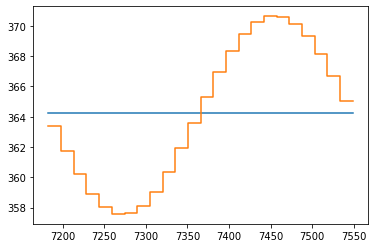

In [4]:
dsets = dict(
    er=dict(source_class=LowEnergyERSource),
    nr=dict(source_class=LowMassWIMPSource),
    nr_mod=dict(source_class=LowMassWIMPModulationSource))

for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](
        batch_size=300 if have_gpu else 10, 
        max_sigma=5)
    
nr_conditions = ['nr', 'nr_mod']

for nrc in nr_conditions:
    dsets[nrc]['source'].energy_hist.sum(axis=1).plot()

## Compute rate histograms

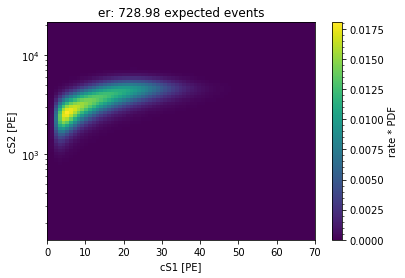

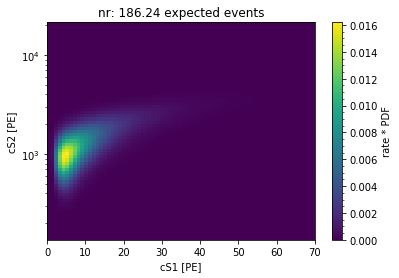

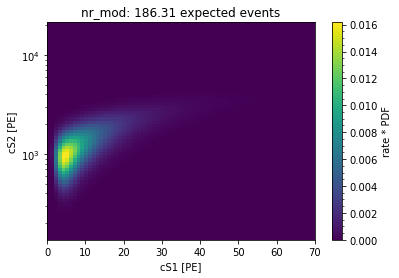

In [6]:
def std_axes():
    plt.yscale('log')
    plt.xlabel("cS1 [PE]")
    plt.ylabel("cS2 [PE]")


# Restore histograms
with open('hists_1e6_20200123.pkl', mode='rb') as f:
    hists = pickle.load(f)
    for dname, q in dsets.items():
        if dname not in hists:
            continue
        q['mh'] = hists[dname]

remake_hists = False

for dname, q in dsets.items():

    if remake_hists or not 'mh' in q:
        print(f"Building histogram for {dname}")
        
        mh = Histdd(bins=(
            np.linspace(0, 70, 71 + 1),
            np.geomspace(10**1.7 / (1 - 0.63),
                         10**3.9 / (1 - 0.63), 
                         70)))
        
        n_batches = 100 if dname == 'er' else 40
        trials_per_batch = int(1e6)

        for _ in tqdm(range(n_batches)):
            d = q['source'].simulate(trials_per_batch)
            add_corrected_signals(d)
            mh.add(d['cs1'], d['cs2'])
        
        # Convert to PDF
        mh /= mh.bin_volumes() * trials_per_batch * n_batches

        # Multiply by total expected event rate
        # (from the source, i.e. before correcting for efficiencies)
        mh *= q['source'].mu_before_efficiencies()

        q['mh'] = mh

    q['events_per_bin'] = q['mh'] * q['mh'].bin_volumes()
    q['mh'].plot(cblabel='rate * PDF')
    plt.title(f"{dname}: {q['events_per_bin'].n:.02f} expected events")
    std_axes()

    plt.show()

In [7]:
# # If you save histograms, remember to download them!!
# with open('hists_1e6_20200123.pkl', mode='wb') as f:
#     pickle.dump({
#         k: v['mh'] 
#         for k, v in dsets.items()}, f)

  * Make sure none of the models are 'cut off' in cS1 / cS2, since cS1 and cS2 cut acceptances are not currently accounted for in our likelihood (unlike S1 or S2 cuts). This is not a limitation of flamedisx: the correction value is known for each event since the correction depends only on observables, so ultimately a cS1 cut is just a space-dependent S1 cut (which flamedisx fully supports).
  * The ROC curves will depend on the extent of the ER spectrum. If you include more high-energy ER events that can be discriminated anyway, the ER leakage in any likelihood will go down. The key figure of merit we are trying to derive here, the decrease in ER leakage at ~50 % NR acceptance when switching to the full likelihood, should be unaffected by this.

## Histogram-based discrimination

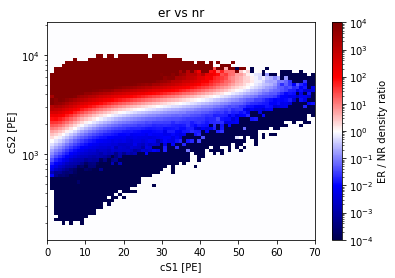

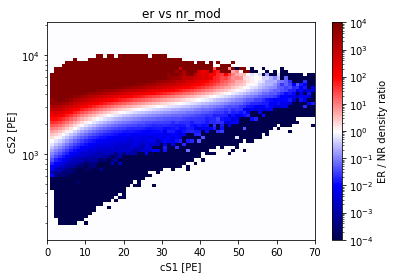

In [8]:
for dname in nr_conditions:
    q = dsets[dname]
    q['signal_background_ratio'] = ratio = \
        (dsets['er']['mh'] + 1e-20)/(q['mh'] + 1e-20)
    q['histogram_ordering'] = np.argsort(ratio.histogram.ravel())

    ratio.plot(log_scale=True, cmap=plt.cm.seismic, 
           vmin=1e-4, vmax=1e4, cblabel='ER / NR density ratio')
    std_axes()
    plt.title(f"er vs {dname}")
    plt.show()

Text(0, 0.5, 'NR acceptance')

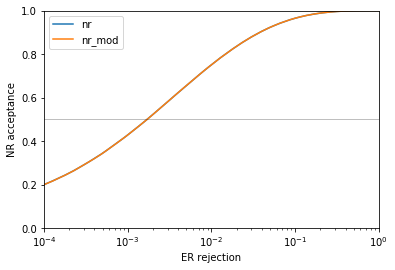

In [9]:
plt.figure()
plt.gcf().patch.set_facecolor('white')

def hist_to_cdf(hist, ordering):
    return np.cumsum(hist.histogram.ravel()[ordering])/hist.n

for dname in nr_conditions:
    q = dsets[dname]
    q['roc_from_histogram'] = (
        hist_to_cdf(dsets['er']['events_per_bin'], q['histogram_ordering']),
        hist_to_cdf(q['events_per_bin'], q['histogram_ordering']))

    plt.plot(*q['roc_from_histogram'], label=dname)

plt.xscale('log')
plt.legend(loc='best')
plt.axhline(0.5, alpha=0.5, c='k', linewidth=0.5)

plt.xlim(1e-4, 1)
plt.xlabel("ER rejection")

plt.ylim(0, 1)
plt.ylabel("NR acceptance")


As expected, there is no difference between NR with and without modulation, since the 2D histogram does not see time.

## Flamedisx-based discrimination

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

# Load earlier results: 
# fn = '/content/drive/My Drive/flamedisx_data/discstudy_20200123_1e6_maxsigma5.pkl.gz'
fn = 'discstudy_20200123_1e6_maxsigma5.pkl.gz'
with gzip.open(fn, mode='rb') as f:
   q = pickle.load(f)
   for k, v in q.items():
       dsets[k]['data'] = v

In [14]:
remake_data = False
n_trials_events = int(1e6) # if have_gpu else int(1e4)

for dname, q in dsets.items():
    # Get simulated data
    if remake_data or 'data' not in q:
        print(f"Simulating data for {dname}")
        q['data'] = sim_data = q['source'].simulate(n_trials_events)
        add_corrected_signals(sim_data)
        
        # Ensure cs1 and cs2 are in range of the histogram
        # to avoid extrapolation in multihist's lookup.
        # NB: we are assuming both histograms have the same binning here!
        bes = q['mh'].bin_edges
        mask = (
            (bes[0][0] <= sim_data['cs1']) & (sim_data['cs1'] < bes[0][-1]) &
            (bes[1][0] <= sim_data['cs2']) & (sim_data['cs2'] < bes[1][-1]))
        print(f"{dname}: Throwing out {100 * (~mask).sum() / len(sim_data):.2f}% of events")
        q['data'] = sim_data[mask].copy()
    sim_data = q['data']
    
    # Compute differential rates ("likelihoods") for all models ("sources")
    for likelihood_dsetname, likelihood_dset in dsets.items():
        sim_data['l_mh_' + likelihood_dsetname] = likelihood_dset['mh'].lookup(
            sim_data['cs1'], sim_data['cs2'])

        key = 'l_full_' + likelihood_dsetname
        if key not in sim_data:
            print(f"Computing likelihood of {dname} data under {likelihood_dsetname} model")
            likelihood_dset['source'].set_data(sim_data.copy())
            sim_data[key] = likelihood_dset['source'].batched_differential_rate()
        
    # Compute ratios of differential rates ("likelihood ratios")
    # for both histogram- and flamedisx based method.
    for nrc in nr_conditions:
        sim_data[f'lr_mh_{nrc}'] = sim_data['l_mh_er'] / sim_data[f'l_mh_{nrc}']
        sim_data[f'lr_full_{nrc}'] = sim_data['l_full_er'] / sim_data[f'l_full_{nrc}']

In [15]:
# # Save results to gzipped pickle. Compression takes a while; download longer.
# # Don't forget to download it!!
# with gzip.open('discstudy_20200123_1e6_maxsigma5.pkl.gz', mode='wb') as f:
#     pickle.dump({dname: q['data']
#                  for dname, q in dsets.items()},
#                 f)

## Compare differential rates

Compare differential rates. There will be an offset because (cS1, cS2) and (S1, S2) have different ranges/means -- so the rates are differential with respect to different coordinates.

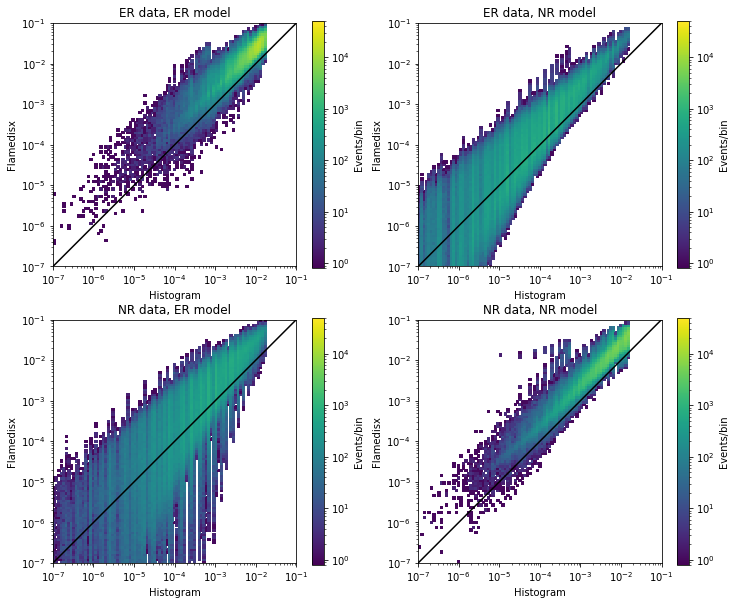

In [16]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

for dn_i, dname in enumerate(['er', 'nr']):
    for lh_i, lh_name in enumerate(['er', 'nr']):
        ax = axes[dn_i, lh_i]
        plt.sca(ax)
        
        q = dsets[dname]['data']
        y, x = q[f'l_full_{lh_name}'], q[f'l_mh_{lh_name}']

        Histdd(x, y,
               bins=(np.geomspace(1e-7, 1e-1, 100),
                     np.geomspace(1e-7, 1e-1, 100))).plot(
            log_scale=True, cblabel='Events/bin',
            vmin=0.8, vmax=n_trials_events * 0.05)

        plt.plot([1e-7, 1e-1], [1e-7, 1e-1], 'k-')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("Histogram")
        plt.ylabel("Flamedisx")
        plt.ylim(1e-7, 1e-1)
        plt.xlim(1e-7, 1e-1)
        plt.title(f"{dname.upper()} data, {lh_name.upper()} model")
        plt.gca().set_aspect(1)
plt.show()

In [17]:
# # Zoom-in on the low-energy NR data
# d = dsets['nr']['data']
# dsets['er']['mh'].plot(log_scale=True, vmin=1e-6, vmax=1e-1, cmap=plt.cm.Blues, cblabel="Diffrate hist")
# plt.scatter(d['cs1'], d['cs2'], c=d['l_full_er'], s=0.1, 
#             vmax=1e-1, vmin=1e-6, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.Reds)
# plt.colorbar(label='Diffrate Flamedisx')
# plt.xlim(0, 10)
# plt.xlabel("cS1 [PE]")
# plt.ylim(0, 3e3)
# plt.ylabel("cS2 [PE]")

## Compare event-by-event discrimination

In [18]:
# d_er = dsets['er']['data']
# d_nr = dsets['nr']['data']

# for d, alt, cmap in [#(d_er, d_nr, plt.cm.viridis),
#                      (d_nr, d_er, plt.cm.magma)
#                     ]:
#     # For each event in d, find what fraction of the alt data is more NR-like than it
#     # (under both likelihoods)
#     f_above = {
#         lt: np.searchsorted(np.sort(alt[f'lr_{lt}_nr'].values), 
#                             d[f'lr_{lt}_nr'].values).astype(np.float) / len(alt)
#         for lt in ('mh', 'full')}

#     # Get ratio. 
#     #   0 = mh sees the event as more NR-like than any of the alt data
#     #   > 1: mh is worse at discriminating, < 1 mh is better at discriminating
#     ratio = f_above['mh'] / f_above['full']
#     mask = np.isfinite(ratio)
    
#     xkey, ykey = 's1', 'z'
    
#     plt.scatter(d[xkey][mask], d[ykey][mask], c=ratio[mask], #cmap=cmap,
#                 vmin=0, vmax=2, cmap=plt.cm.seismic,
#                 s=0.2,)
#     plt.colorbar()
#     plt.scatter(d[xkey][~mask], d[ykey][~mask], c='g',
#                 s=0.2, alpha=0.2)
    
#     plt.xlabel(xkey)
#     #plt.ylim(0, 700)
#     plt.ylabel(ykey)
#     plt.show()

For these NR events, red events have a more NR-like ER/NR likelihood ratio in flamedisx, and blue ones in the histogram likelihood. For green events the ratio of the two likelihood ratios is not a finite number.

Log likelihood ratio histograms for ER and NR data under both likelihoods below. Note many events are at the edges for the histogram likelihood; for these either the NR or ER histogram was zero, and we clip the likelihood ratio.

Found 0 NaNs for mh:er
Found 2 NaNs for mh:nr
Found 0 NaNs for full:er
Found 0 NaNs for full:nr
Found 0 NaNs for full:er
Found 0 NaNs for full:nr_mod


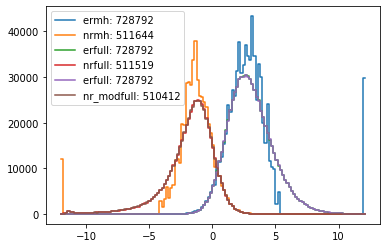

In [19]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt, nrc, color in [['mh', 'nr', 'b'], ['full', 'nr', 'g'], ['full', 'nr_mod', 'purple']]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        if dname not in ('er', nrc):
            continue

        d = q['data'][f'lr_{lt}_{nrc}']
        print(f"Found {np.sum(np.isnan(d))} NaNs for {lt}:{dname}")
        clip_exp = 12
        hists[dname] = Hist1d(
            np.log10(d.clip(10**-clip_exp, 10**clip_exp).values.astype('float')),
            bins=np.linspace(-clip_exp, clip_exp + 0.1, 140))
        hists[dname].plot(label=f"{dname}{lt}: {hists[dname].n}")
#plt.yscale('log')
plt.legend()

plt.show()

## ROC Curves

In [20]:
def binom_interval(success, total, conf_level=0.95):
    """Confidence interval on binomial - using Jeffreys interval
    Code stolen from https://gist.github.com/paulgb/6627336
    Agrees with http://statpages.info/confint.html for binom_interval(1, 10)
    """
    # TODO: special case for success = 0 or = total? see wikipedia
    quantile = (1 - conf_level) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    
    # If something went wrong with a limit calculation, report the trivial limit
    lower[np.isnan(lower)] = 0
    upper[np.isnan(upper)] = 1
    return lower, upper


rocs = dict()

for lt, nrc, color in [['mh', 'nr', 'b'], ['full', 'nr', 'g'], ['full', 'nr_mod', 'purple']]:
    hists = dict()
    cdfs = dict()
    cdf_intervals = dict()
    for dname, q in dsets.items():
        hists[dname] = Hist1d(
            np.log10(q['data'][f'lr_{lt}_{nrc}'].clip(1e-20, 1e20)),
            bins=np.linspace(-21, 21, 10000))
        
        cdfs[dname] = hists[dname].cumulative_density
        cdf_intervals[dname] = np.stack(binom_interval(
            np.cumsum(hists[dname].histogram),
            hists[dname].n, 
            conf_level=.68))
        
    rocs[(lt, nrc)] = dict(hists=hists, cdfs=cdfs, cdf_intervals=cdf_intervals)

roc_labels = {('mh', 'nr'): "2d Hist (sampled)",
              ('full', 'nr'): "Flamedisx",
              ('full', 'nr_mod'): "Fd modulation"}
roc_colors = {('mh', 'nr'): 'b',
              ('full', 'nr'): 'g',
              ('full', 'nr_mod'): 'darkorange'}

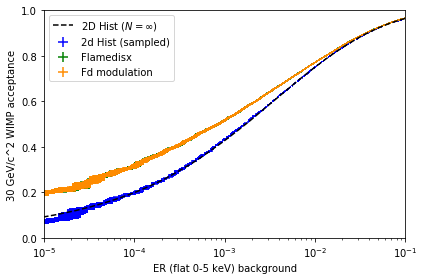

In [21]:
for rn, roc in rocs.items():
    x, y = roc['cdfs']['er'], roc['cdfs']['nr']
    plt.errorbar(x, y,
                 xerr=np.abs(roc['cdf_intervals']['er'] - x),
                 yerr=np.abs(roc['cdf_intervals']['nr'] - y),
                 linestyle='',
                 color=roc_colors[rn],
                 label=roc_labels[rn])
plt.plot(*dsets['nr']['roc_from_histogram'], 
         label='2D Hist ($N = \infty$)',
         color='k', linestyle='--')
     
plt.xlabel("ER (flat 0-5 keV) background")
plt.ylabel(f"{LowMassWIMPSource.mw} GeV/c^2 WIMP acceptance")
plt.xscale('log')
plt.xlim(1e-5, 1e-1)
plt.ylim(0., 1)
plt.legend(loc='best')

plt.tight_layout()
plt.savefig('fd_roc.png', dpi=200)
plt.show()

/home/aalbers/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/aalbers/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


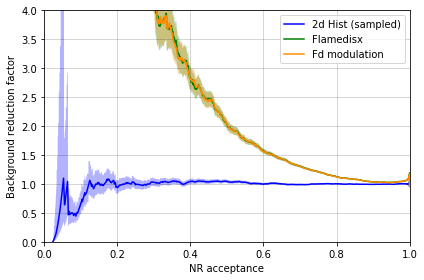

In [22]:
def bg_reduction_factor(nr_acceptance, er_leakage):
    orig_roc = dsets['nr']['roc_from_histogram']
    leakage_hist = np.interp(nr_acceptance, orig_roc[1], orig_roc[0])
    return leakage_hist / er_leakage

for rocname, roc in rocs.items():
    acc, leak = roc['cdfs']['nr'], roc['cdfs']['er']   
    red = bg_reduction_factor(acc, leak)
    red_bounds = np.stack([
        bg_reduction_factor(acc, q)
        for q in roc['cdf_intervals']['er']])

    plt.plot(acc, 
             red, 
             label=roc_labels[rocname], 
             color=roc_colors[rocname])
    plt.fill_between(acc,
                     red_bounds.min(axis=0), 
                     red_bounds.max(axis=0), 
                     color=roc_colors[rocname],
                     alpha=0.3, linewidth=0, step='mid')  
    
    # If you're really paranoid, you might want to plot the xerror too:
    # plt.errorbar(acc, 
    #              red, 
    #              xerr=np.abs(roc['cdf_intervals']['nr'] - acc),
    #              yerr=[red - red_bounds.min(axis=0),
    #                    red_bounds.max(axis=0) - red],
    #              label=roclabels[rocname])

plt.legend(loc='best')
plt.grid(alpha=0.2, c='k', linestyle='-')

plt.xlabel("NR acceptance")
plt.ylabel("Background reduction factor")

plt.ylim(0, 4)
plt.xlim(0, 1)

#plt.ylim(0.8, 1.2)
plt.tight_layout()
plt.savefig('fd_bg_reduction.png', dpi=200)

## Compare sensitivity

Create likelihoods for:
  1. ER vs NR histogram-based
  2. ER vs NR flamedisx
  3. ER vs NR-mod histogram-based -- could omit, should be same as (1)
  4. ER vs NR-mod flamedisx

Sources are represented by `ColumnSource`s, with a simulate method that draws from `dsets[dname]['data']`.


In [23]:
class FastSource(fd.ColumnSource):

    def _differential_rate(self, data_tensor, ptensor):
        return self._fetch(self.column, data_tensor) * self.scale_by

    def random_truth(self, n_events, fix_truth=None, **params):
        if fix_truth is not None or len(params):
            raise NotImplementedError
        return dsets[self.dname]['data'].sample(n_events)

mu_of_source = dict(er=10000, nr=10, nr_mod=10)
likelihood_types = ('mh', 'full')

fast_sources = {
    ltype: {
        dname: type(
            f'FS_{dname}_{ltype}', 
            (FastSource,), 
            dict(column=f'l_{ltype}_{dname}',
                 dname=dname,
                 # Adjust mu to the desired value, scaling
                 # the differential rate accordingly
                 mu=mu_of_source[dname],
                 scale_by=mu_of_source[dname]/dsets[dname]['events_per_bin'].n
                 ))
        for dname in dsets.keys()}
    for ltype in likelihood_types}

likelihoods = {
    ltype: {
        nrc: fd.LogLikelihood(
            sources=dict(er=fast_sources[ltype]['er'],
                         nr=fast_sources[ltype][nrc]),
            free_rates=('er', 'nr'),
            # max_sigma and n_trials are irrelevant for ColumnSource
            batch_size=15000)
        for nrc in nr_conditions}
    for ltype in likelihood_types}


Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]
Estimating mus: 0it [00:00, ?it/s]


In [24]:
# # Check simulated events are reasonable
# ll = likelihoods['full']['nr']
# for sname, color in [['er', 'b'], ['nr', 'r']]:
#     d = ll.sources[sname].simulate(1000)
#     plt.scatter(d['cs1'], d['cs2'], color=color, s=1)
# likelihoods['full']['nr']
# d = ll.simulate()
# plt.scatter(d['cs1'], d['cs2'], s=1, c='g')
# from collections import Counter
# Counter(d['source'].values)

Time for 400 trials, 1e4 ER events /trials, minuit, default tolerance:
  * master 23 January, colab GPU: 41 minutes
  * trace_likelihood 25 January, Jelle's laptop: 5 minutes

In [ ]:
n_trials = 1000

import pandas as pd

sensi_results = {
    ltype: {
        nrc: pd.DataFrame(
            dict(t=np.zeros(n_trials),
                 bestfit_nr=np.zeros(n_trials),
                 bestfit_er=np.zeros(n_trials),
                 condfit_er=np.zeros(n_trials),
                 limit=np.zeros(n_trials))).to_records()
        for nrc in nr_conditions}
    for ltype in likelihood_types}

truth = dict(nr_rate_multiplier=0., er_rate_multiplier=1.)
guess = dict(nr_rate_multiplier=1., er_rate_multiplier=1.)

for trial_i in tqdm(range(n_trials)):
    # The nr model choice changes what events we need to pick from,
    # so this has to be the outer loop.
    for nrc in nr_conditions: 

        # Draw simulated events.
        # The histogram and flamedisx likelihood draw from the same
        # event reservoir (they just look at different columns later)
        d = likelihoods['mh'][nrc].simulate(**truth)

        for ltype in likelihood_types:
            q = sensi_results[ltype][nrc]

            ll = likelihoods[ltype][nrc]
            ll.set_data(d)

            bf = ll.bestfit(guess=guess, optimizer='minuit', llr_tolerance=1e-9)
            q['bestfit_nr'][trial_i] = bf['nr_rate_multiplier']
            q['bestfit_er'][trial_i] = bf['er_rate_multiplier']

            cf = ll.bestfit(guess=dict(er_rate_multiplier=bf['er_rate_multiplier']),
                            fix=dict(nr_rate_multiplier=0.))
            q['condfit_er'][trial_i] = cf['er_rate_multiplier']

            q['t'][trial_i] = 2 * (
                ll(**bf) - ll(er_rate_multiplier=cf['er_rate_multiplier'],
                              nr_rate_multiplier=truth['nr_rate_multiplier']))

            q['limit'][trial_i] = ll.limit('nr_rate_multiplier', bestfit=bf)

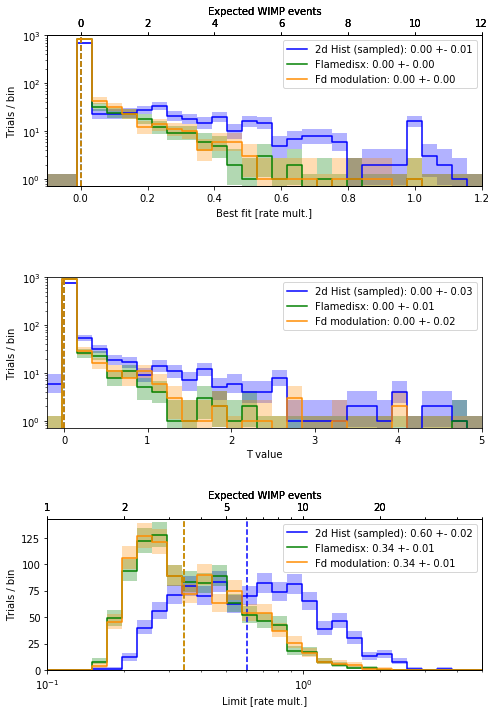

In [51]:
f, axes = plt.subplots(3, 1, figsize=(7, 10))

def hist_plot(data, bins, color, label):
    data = data[np.isfinite(data)]
    mean = np.mean(data)
    # Error calculation is very dodgy, since dist
    # is far from Gaussian.
    err = np.std(data)/len(data)**0.5

    Hist1d(data, bins=bins).plot(
        color=color, 
        set_xlim=True,
        errors=True,
        error_style='band',
        label=f'{label}: {mean:.2f} +- {err:.2f}')
    plt.axvline(mean,
                color=color,
                linestyle='--')
    plt.legend(loc='best')


def twin_nevents(rm_bins, log=False, ticks=None):
    ax = plt.twiny()
    plt.sca(ax)
    plt.xlabel("Expected WIMP events")
    if log:
        plt.xscale('log')
        ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if ticks is not None:
        plt.xticks(ticks)
    plt.xlim(rm_bins[0] * mu_of_source['nr'],
             rm_bins[-1] * mu_of_source['nr'])


n_bins = 30

for ltype in likelihood_types:
    for nrc in nr_conditions: 
        if (ltype, nrc) not in rocs:
            continue
        color = roc_colors[(ltype, nrc)]
        label = roc_labels[(ltype, nrc)]
        q = sensi_results[ltype][nrc]

        plt.sca(axes[0])
        bins = np.linspace(-0.1, 1.2, n_bins)
        hist_plot(q['bestfit_nr'],
                  bins=bins,
                  label=label, color=color)
        plt.xlabel("Best fit [rate mult.]")
        twin_nevents(bins)
        plt.yscale('log')
        plt.ylim(0.7, n_trials)
        

        plt.sca(axes[1])
        hist_plot(q['t'],
                  bins=np.linspace(-0.2, 5, n_bins),
                  label=label, color=color)
        plt.xlabel("T value")
        plt.yscale('log')
        plt.ylim(0.7, n_trials)

        plt.sca(axes[2])
        bins = np.geomspace(0.1, 5, n_bins)
        hist_plot(q['limit'], 
                  bins=bins,
                  label=label, color=color)
        plt.xlabel("Limit [rate mult.]")
        plt.xscale('log')
        plt.ylim(0, max(10, n_trials / 7))
        twin_nevents(bins, log=True, ticks=[1, 2, 5, 10, 20])

for ax in axes:
    ax.set_ylabel("Trials / bin")

plt.tight_layout()
plt.subplots_adjust(hspace=0.6)
plt.savefig('sensitivity_results_bigexp.png', 
            dpi=200,
            bbox_inches='tight')

  * Increase exposure -> expect modulation recovery, more flamedisx improvements
  * Decrease elife -> similar
  * Optimizer tolerance for bestfit ~0 fraction problem (otherwise try minuit, etc)
  * Investigate weird fraction in fd vs hist likelihood: numerical error?

In [0]:
# Do not forget to download!!
with open('sensi_results_20200123_20.pkl', mode='wb') as f:
    pickle.dump(sensi_results, f)